In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import tensorflow as tf
import os
import time
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from nolearn.lasagne import BatchIterator
%matplotlib inline

/Users/purvil12c/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
count=0
count_all=-1
keypoints_count=[0]*31
headings=[""]*31

image_x=[] #image pixel values
y=[] #keypoints data

In [4]:
with open('/Users/purvil12c/Desktop/Machine Learning/Dataset Facial/training.csv', 'r') as f:
    reader = csv.reader(f)
    count=0
    for row in reader:
        count=count+1
        i=0
        flag=0
        for item in row:
            if(count==1):
                headings[i]=item
            else:
                if(item!=''):
                    keypoints_count[i]+=1
                else:
                    flag=1
            i+=1
        if(flag==0 and count!=1):
            count_all+=1
            i=0
            temp=[]
            for item in row:
                if(i==30):
                    image_temp=item
                    image_temp=image_temp.replace(' ',',')
                    image_temp=np.fromstring(image_temp, sep=',')
                    #image_temp = np.reshape(image_temp, (96, 96))
                    image_x.append(image_temp)
                else:
                    temp.append(float(item))
                
                i+=1
            y.append(temp)       
            
        count+=1

In [5]:
for i in range(31):
    print(headings[i],keypoints_count[i])
print("Images with all attributes - ",count_all)

('left_eye_center_x', 7039)
('left_eye_center_y', 7039)
('right_eye_center_x', 7036)
('right_eye_center_y', 7036)
('left_eye_inner_corner_x', 2271)
('left_eye_inner_corner_y', 2271)
('left_eye_outer_corner_x', 2267)
('left_eye_outer_corner_y', 2267)
('right_eye_inner_corner_x', 2268)
('right_eye_inner_corner_y', 2268)
('right_eye_outer_corner_x', 2268)
('right_eye_outer_corner_y', 2268)
('left_eyebrow_inner_end_x', 2270)
('left_eyebrow_inner_end_y', 2270)
('left_eyebrow_outer_end_x', 2225)
('left_eyebrow_outer_end_y', 2225)
('right_eyebrow_inner_end_x', 2270)
('right_eyebrow_inner_end_y', 2270)
('right_eyebrow_outer_end_x', 2236)
('right_eyebrow_outer_end_y', 2236)
('nose_tip_x', 7049)
('nose_tip_y', 7049)
('mouth_left_corner_x', 2269)
('mouth_left_corner_y', 2269)
('mouth_right_corner_x', 2270)
('mouth_right_corner_y', 2270)
('mouth_center_top_lip_x', 2275)
('mouth_center_top_lip_y', 2275)
('mouth_center_bottom_lip_x', 7016)
('mouth_center_bottom_lip_y', 7016)
('Image', 7049)
('Images

In [6]:
#List to numpy array

image_x=np.asarray(image_x)
y=np.asarray(y)

#Normalising Image pixel values - 
image_x=image_x/255
y=(y-48)/48

In [7]:
print image_x.shape

(2140, 9216)


In [8]:
print type(image_x)
print image_x[0]

<type 'numpy.ndarray'>
[ 0.93333333  0.9254902   0.92941176 ...,  0.2745098   0.29411765
  0.35294118]


In [9]:
print type(y)

<type 'numpy.ndarray'>


In [10]:
print y[0]

[ 0.37569925 -0.18745263 -0.37027068 -0.24121504  0.24129323 -0.17401203
  0.52354887 -0.16729173 -0.24257143 -0.22105414 -0.5113985  -0.22105414
  0.18652632 -0.39513233  0.6713985  -0.32858045 -0.16192481 -0.39578496
 -0.65924211 -0.38234436 -0.07457143  0.18889173  0.27490226  0.66604511
 -0.40386466  0.61227068 -0.09765414  0.51948872 -0.10144361  0.7601203 ]


In [11]:
def plotSample(image,y,y_correct,check):
    image=image.reshape(96, 96)
    plt.imshow(image,zorder=0,cmap='gray')
    i=0
    while i!=30:
        plt.scatter(y[i]*48 + 48,y[i+1]*48 + 48,10,c='W',zorder=1)#(x,y,size,color,zorder)
        i=i+2
    i=0
    if(check==True):
        while i!=30:
            plt.scatter(y_correct[i]*48 + 48,y_correct[i+1]*48 + 48,10,c='r',zorder=2)#(x,y,size,color,zorder)
            i=i+2
    print(check)

False


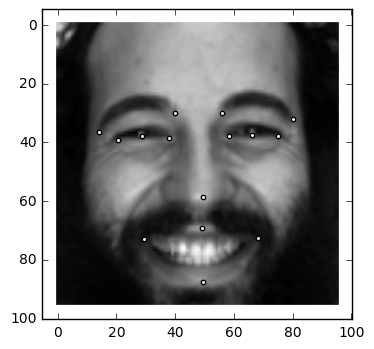

In [12]:
image_x, y = shuffle(image_x, y, random_state=42) #Shuffling the deck of images
plotSample(image_x[0],y[0],[],False)

In [28]:
#constants - 
image_size=96
num_keypoints=30
batch_size=36
num_epochs=1000
learning_rate = 0.01
momentum = 0.9
num_hidden_layer_1=100

model_name = "1fc_b" + str(batch_size) + "_e" + str(num_epochs - 1)
model_variable_scope = model_name

In [14]:
x_train, x_test, y_train, y_test = train_test_split(image_x, y, test_size = 0.3)
print x_train.shape

(1498, 9216)


In [15]:
def neural_network_model(data):
    hidden_1_layer={'weights':tf.Variable(tf.random_normal([image_size*image_size,num_hidden_layer_1])),'biases':tf.Variable(tf.random_normal([num_hidden_layer_1]))}
    output_layer={'weights':tf.Variable(tf.random_normal([num_hidden_layer_1,num_keypoints])),'biases':tf.Variable(tf.random_normal([num_keypoints]))}
    l1=tf.add(tf.matmul(data,hidden_1_layer['weights']),hidden_1_layer['biases'])
    l1=tf.nn.relu(l1) #This is an activation function. Data is passed through activation function
    o1=tf.matmul(l1,output_layer['weights']) + output_layer['biases']
    return o1 #ol is output

In [16]:
def calc_loss(predictions, labels):
    #calculates loss between actual and predicted.
    return np.mean(np.square(predictions - labels))

In [31]:
graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size * image_size))
    tf_y_batch = tf.placeholder(tf.float32, shape = (None, num_keypoints))
    
    # Training computation.
    with tf.variable_scope(model_variable_scope):
        predictions = neural_network_model(tf_x_batch)
    
    loss = tf.reduce_mean(tf.square(predictions - tf_y_batch))

    # Optimizer.
    optimizer = tf.train.MomentumOptimizer(
        learning_rate = learning_rate, 
        momentum = momentum, 
        use_nesterov = True
    ).minimize(loss)

In [32]:
def get_predictions_in_batches(X, session):
    """
    Calculates predictions in batches of 128 examples at a time, using `session`'s calculation graph.
    
    Parameters
    ----------
    X       : ndarray
              Dataset to get predictions for.
    session :
              TensorFlow session to be used for predicting. Is expected to have a `predictions` var 
              in the graph along with a `tf_x_batch` placeholder for incoming data.
               
    Returns
    -------
    N-dimensional array of predictions.
    """
    p = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, _ in batch_iterator(X):
        [p_batch] = session.run([predictions], feed_dict = {
                tf_x_batch : x_batch 
            }
        )
        p.extend(p_batch)
    return p

In [33]:
predict=[]
with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    print("Training NOW!")
    for epoch in range(num_epochs):
        batch_iterator = BatchIterator(batch_size=batch_size,shuffle = True)
        for x_batch, y_batch in batch_iterator(x_train,y_train):
            session.run([optimizer],feed_dict = { tf_x_batch : x_batch, tf_y_batch : y_batch})
            
         
        train_loss = calc_loss(get_predictions_in_batches(x_train,session),y_train)
           
        predict=get_predictions_in_batches(x_test,session)
        test_loss=calc_loss(predict,y_test)
        print("EPOCH ",epoch," Train Loss ",train_loss," Test Loss ",test_loss)
    
    correct = tf.equal(tf.argmax(predictions,1),tf.argmax(tf_y_batch,1))
    accuracy=tf.reduce_mean(tf.cast(correct,'float'))
    print("Accuracy is = ",accuracy.eval(feed_dict={tf_x_batch:x_test,tf_y_batch:y_test}))
    save_path = saver.save(session, "/Users/purvil12c/model.ckpt")
    print("Model saved in file: %s" % save_path)

Training NOW!
('EPOCH ', 0, ' Train Loss ', 2.3523515071410303e+29, ' Test Loss ', 2.3523515071410303e+29)
('EPOCH ', 1, ' Train Loss ', 2.6328938255862093e+29, ' Test Loss ', 2.632893825586209e+29)
('EPOCH ', 2, ' Train Loss ', 1.4681518811848192e+29, ' Test Loss ', 1.4681518811848192e+29)
('EPOCH ', 3, ' Train Loss ', 8.0864470710569085e+28, ' Test Loss ', 8.0864470710569067e+28)
('EPOCH ', 4, ' Train Loss ', 4.4527848842878472e+28, ' Test Loss ', 4.4527848842878472e+28)
('EPOCH ', 5, ' Train Loss ', 2.4519031208879253e+28, ' Test Loss ', 2.4519031208879253e+28)
('EPOCH ', 6, ' Train Loss ', 1.3501279956347486e+28, ' Test Loss ', 1.3501279956347483e+28)
('EPOCH ', 7, ' Train Loss ', 7.4344106383068471e+27, ' Test Loss ', 7.434410638306846e+27)
('EPOCH ', 8, ' Train Loss ', 4.0937204342020909e+27, ' Test Loss ', 4.0937204342020915e+27)
('EPOCH ', 9, ' Train Loss ', 2.2541863936004177e+27, ' Test Loss ', 2.2541863936004174e+27)
('EPOCH ', 10, ' Train Loss ', 1.2412561323179085e+27, ' T

In [28]:
from PIL import Image
im = Image.open("/Users/purvil12c/Desktop/Untitled-1.jpg") #Can be many different formats.
pix = im.load()
print im.size #Get the width and hight of the image for iterating over

pixel_values = []
for i in range(96):
    for j in range(96):
        
        avg=(pix[j,i][0] + pix[j,i][1] + pix[j,i][2])/3
        pixel_values.append(avg)
        
print len(pixel_values)
img=np.array(pixel_values)

(96, 96)
9216


In [29]:
img=np.reshape(img,(1,9216))

In [34]:
with tf.Session(graph = graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, "/users/purvil12c/model.ckpt")
    predict2=get_predictions_in_batches(img,session)
    predict=get_predictions_in_batches(x_test,session)

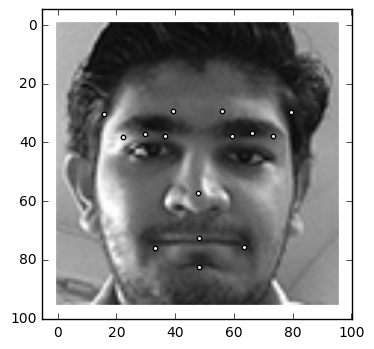

In [47]:
plotSample(img,predict2[0],[],False)

True


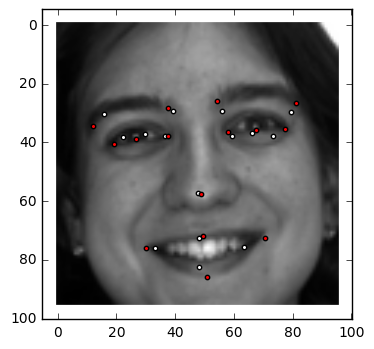

In [102]:
plotSample(x_test[150],predict[150],y_test[150],True)

True


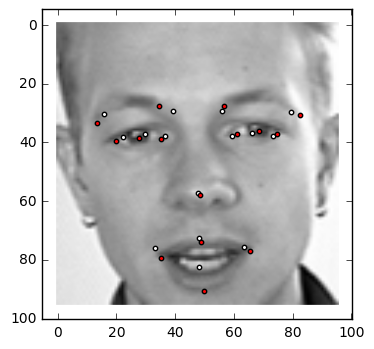

In [103]:
plotSample(x_test[200],predict[200],y_test[200],True)

True


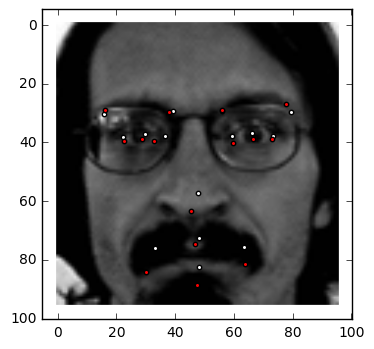

In [104]:
plotSample(x_test[11],predict[11],y_test[11],True)